## Import the libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout
from keras.layers.core import Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


## Load the data

We don't need the labels as the autoencoders are an unsupervised network

In [0]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [3]:
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

print('X_train shape: ', X_train.shape)
print(X_train.shape[0], ' train samples')
print(X_test.shape[0], ' test samples')

X_train shape:  (60000, 28, 28, 1)
60000  train samples
10000  test samples


## Flatten the images for the Fully-Connected Networks

In [0]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Vanilla Autoencoder

## Create the network

The first network is the most simple autoencoder.
It has 3 layers - Input - encoded - decoded

In [0]:
input_size = 784
hidden_size = 64

In [6]:
x = Input(shape = (input_size, ))
h = Dense(hidden_size, activation = 'relu')(x)
r = Dense(input_size, activation = 'sigmoid')(h)

autoencoder = Model(inputs = x, outputs = r)
autoencoder.compile(optimizer = 'adam', loss = 'mse')

W0807 20:06:33.377691 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 20:06:33.395208 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 20:06:33.400713 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 20:06:33.425886 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



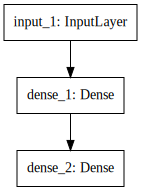

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog = 'dot', format = 'svg'))

## Train

In [8]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          validation_data = (X_test, X_test))

W0807 20:06:33.621917 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0807 20:06:33.687054 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.0445 - val_loss: 0.0223
Epoch 2/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.0173 - val_loss: 0.0129
Epoch 3/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.0109 - val_loss: 0.0087
Epoch 4/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.0078 - val_loss: 0.0066
Epoch 5/5
60000/60000 [==============================] - 1s 24us/step - loss: 0.0062 - val_loss: 0.0055


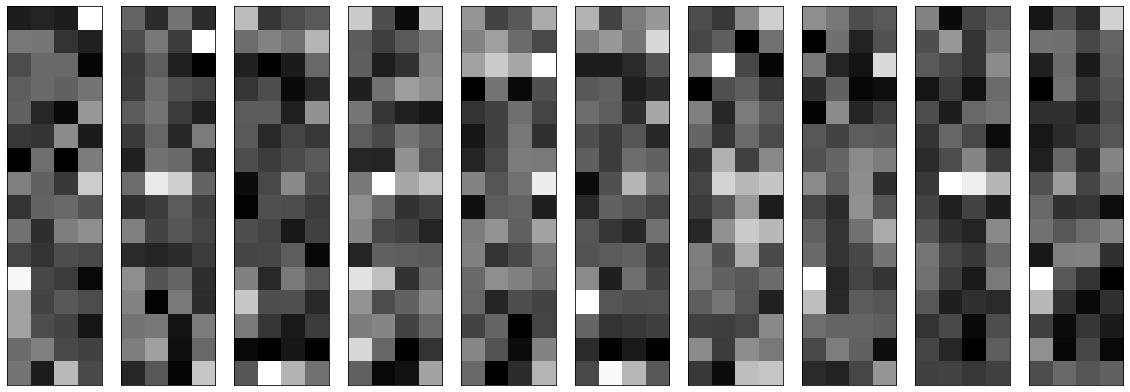

In [9]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize = (20, 8))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(encoded_imgs[i].reshape(4, 16).T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Predict on the test set

In [0]:
decoded_imgs = autoencoder.predict(X_test)

## Plot

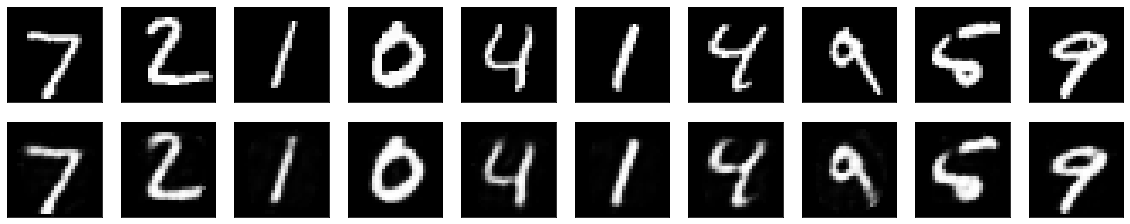

In [11]:
n = 10
plt.figure(figsize = (20, 6))

for i in range(n):
  # display original images
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # display reconstructed images
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Plot the losses

dict_keys(['val_loss', 'loss'])


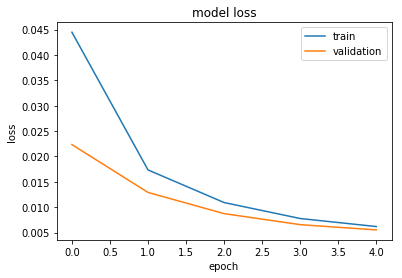

In [12]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

# Multilayer Autoencoder

## Create the network

We extend the idea of the first network to more layers

In [13]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape = (input_size, ))
hidden_1 = Dense(hidden_size, activation = 'relu')(x)
code = Dense(code_size, activation = 'relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation = 'relu')(code)
r = Dense(input_size, activation = 'sigmoid')(hidden_2)

autoencoder = Model(inputs = x, outputs = r)
autoencoder.compile(optimizer = 'adam', 
                    loss = 'binary_crossentropy')

W0807 20:06:43.951799 139991491549056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


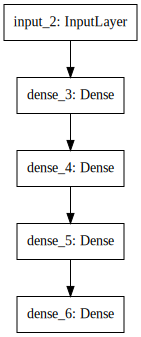

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog = 'dot', format = 'svg'))

## Train the network

In [15]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          validation_data = (X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 38us/step - loss: 0.1814 - val_loss: 0.1170
Epoch 2/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.1078 - val_loss: 0.0997
Epoch 3/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0970 - val_loss: 0.0925
Epoch 4/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0911 - val_loss: 0.0880
Epoch 5/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0875 - val_loss: 0.0850


## Predict on the test set

In [0]:
decoded_imgs = autoencoder.predict(X_test)

## Plot

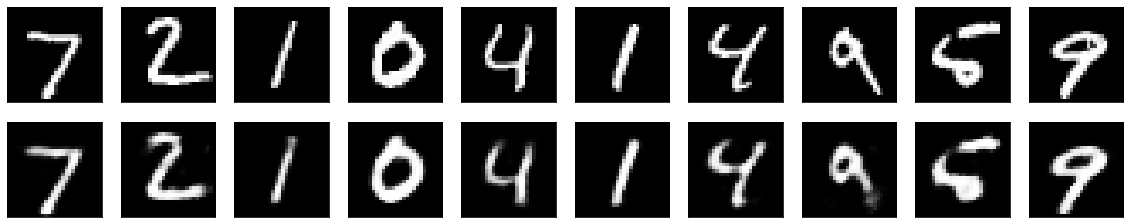

In [17]:
n = 10
plt.figure(figsize = (20, 6))

for i in range(n):
  # Displaying original images
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # Displaying reconstructed images
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
plt.show()

## Plot the losses

dict_keys(['val_loss', 'loss'])


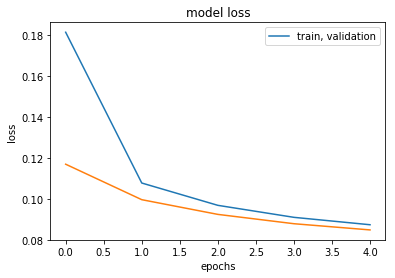

In [18]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train, validation'], loc = 'upper right')
plt.show()

# Convolutional Autoencoder

In [19]:
num_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") /255.

print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

X_train shape:  (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Create the network

This network does not take flattened vectors as an input, but 3D images instead

In [20]:
x = Input(shape = (28, 28, 1))

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
pool1 = MaxPooling2D((2, 2), padding = 'same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(pool1)
pool2 = MaxPooling2D((2, 2), padding = 'same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(pool2)
h = MaxPooling2D((2, 2), padding = 'same')(conv1_3)

# Decoder
conv2_1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation = 'relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(up3)

autoencoder = Model(inputs = x, outputs = r)
autoencoder.compile(optimizer = 'adadelta', 
                    loss = 'binary_crossentropy')

W0807 20:06:56.263381 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0807 20:06:56.307431 139991491549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



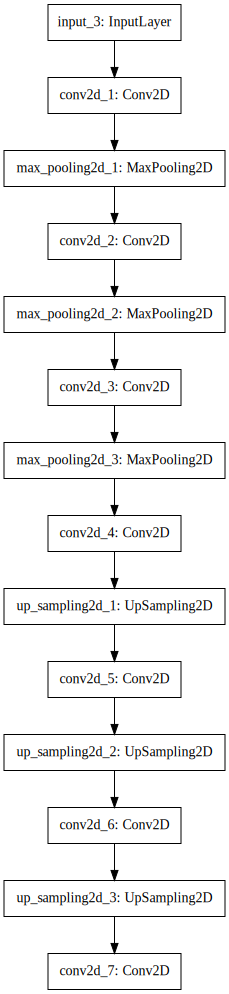

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog = 'dot', format = 'svg'))

## Train

In [22]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          validation_data = (X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 91us/step - loss: 0.2135 - val_loss: 0.1648
Epoch 2/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1558 - val_loss: 0.1423
Epoch 3/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1415 - val_loss: 0.1360
Epoch 4/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1343 - val_loss: 0.1328
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.1300 - val_loss: 0.1269


In [0]:
decoded_imgs = autoencoder.predict(X_test)

## Plot

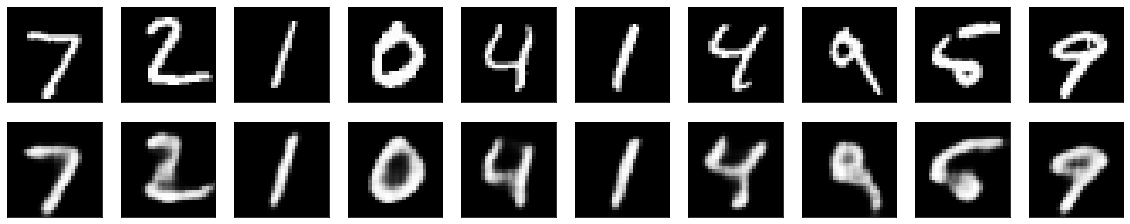

In [24]:
n = 10
plt.figure(figsize = (20, 6))

for i in range(n):
  # Displaying original images
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # Displaying reconstructed images
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
plt.show()

## Plot the losses

dict_keys(['val_loss', 'loss'])


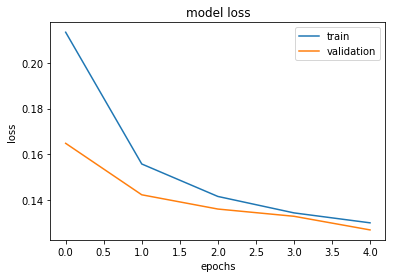

In [25]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

# Sparse Autoencoder

## Create the network

In [0]:
input_size = 784
hidden_size = 32

## Normalizing the data, flattening the images

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [0]:
x = Input(shape = (input_size, ))
h = Dense(hidden_size, activation = 'relu',
          activity_regularizer = regularizers.l1(10e-6))(x)
r = Dense(input_size, activation = 'sigmoid')(h)

autoencoder = Model(inputs = x, outputs = r)
autoencoder.compile(optimizer = 'Adam', 
                    loss = 'binary_crossentropy')

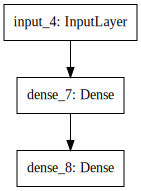

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog = 'dot', format = 'svg'))

In [30]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          validation_data = (X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 35us/step - loss: 0.5888 - val_loss: 0.4959
Epoch 2/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.4239 - val_loss: 0.3600
Epoch 3/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.3104 - val_loss: 0.2663
Epoch 4/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.2318 - val_loss: 0.2009
Epoch 5/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.1763 - val_loss: 0.1541
Epoch 6/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.1362 - val_loss: 0.1200
Epoch 7/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.1067 - val_loss: 0.0946
Epoch 8/15
60000/60000 [==============================] - 2s 30us/step - loss: 0.0846 - val_loss: 0.0754
Epoch 9/15
60000/60000 [==============================] - 2s 29us/step - loss: 0.0677 - val_loss: 0.0606
Epoch

## Predict on the test set

In [0]:
decoded_imgs = autoencoder.predict(X_test)

## Plot

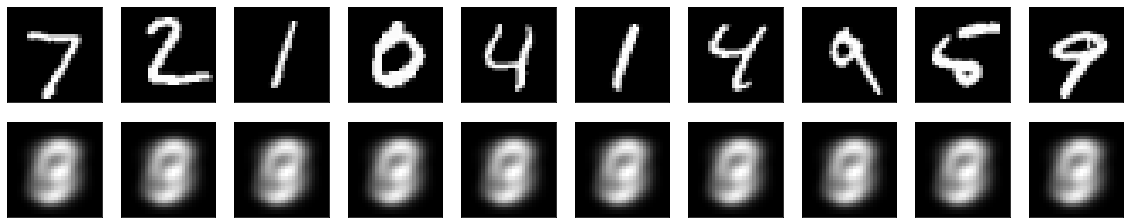

In [32]:
n = 10
plt.figure(figsize = (20, 6))

for i in range(n):
  # Displaying original images
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # Displaying reconstructed images
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
plt.show()

I don't know what the fuck is wrong, if anybody figures it out, please help me out.

## Plot the losses

dict_keys(['val_loss', 'loss'])


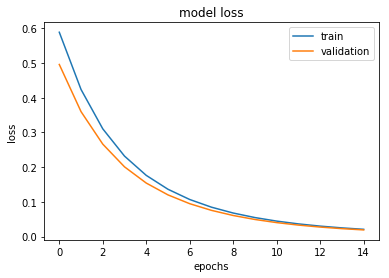

In [33]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

# Denoising Autoencoder

In [0]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

## Create noisy data

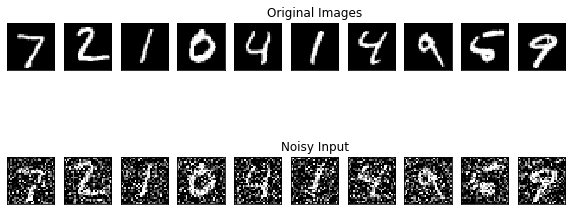

In [35]:
noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(size = X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(size = X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

n = 10
plt.figure(figsize = (10, 4.5))
for i in range(n):
  # Plotting original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Original Images')
    
  # Plotting noisy images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(X_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Noisy Input')

## Create the network

In [0]:
x = Input(shape = (28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
pool1 = MaxPooling2D((2, 2), padding = 'same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(pool1)
h = MaxPooling2D((2, 2), padding = 'same')(conv1_2)

# Decoder
conv2_1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(up2)

autoencoder = Model(inputs = x, outputs = r)
autoencoder.compile(optimizer = 'adadelta', 
                    loss = 'binary_crossentropy')

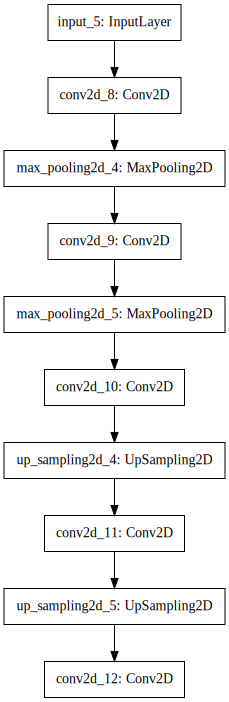

In [37]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog = 'dot', format = 'svg'))

## Train the network

In [38]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train,
                          batch_size = batch_size,
                          epochs = epochs,
                          verbose = 1,
                          validation_data = (X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.1827 - val_loss: 0.1274
Epoch 2/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.1210 - val_loss: 0.1129
Epoch 3/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.1127 - val_loss: 0.1099
Epoch 4/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.1090 - val_loss: 0.1104
Epoch 5/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.1065 - val_loss: 0.1067


In [0]:
decoded_imgs = autoencoder.predict(X_test_noisy)

## Plot

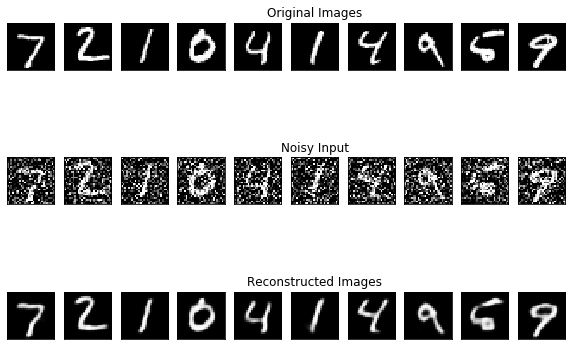

In [40]:
n = 10
plt.figure(figsize = (10, 7))

for i in range(n):
  # Plotting original images
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Original Images')
    
  # Plotting noisy images
  ax = plt.subplot(3, n, i + n + 1)
  plt.imshow(X_test_noisy[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Noisy Input')
    
  # Plotting reconstructed images
  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i == n/2:
    ax.set_title('Reconstructed Images')

## Plot the losses

dict_keys(['val_loss', 'loss'])


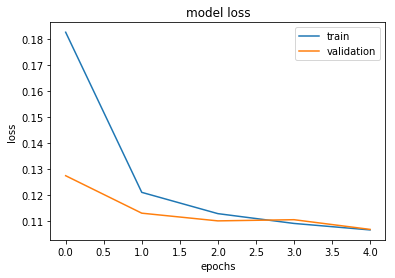

In [41]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()